In [37]:
import pandas as pd
kpc2cm, Myr2sec = 3.08567758e21, 31557600000000.

In [77]:
data = pd.concat([pd.read_csv('/data/a3data/pythia8157/main_antihelium/sep_'+str(i)+'__dbar', delimiter=' ', header=None, names=('E_CMS', 'A', 'Z','E_d','p_coal','method','weight')) for i in range(0,10)])
print data

data['E_d'] /= 2. # Divide by nucleon number (T/n)

      E_CMS  A  Z        E_d     p_coal  method  weight
0       200 -2 -2   4.518270   0.124630       0     1.0
1       200 -2  0  13.047400   0.119937       0     1.0
2       200 -2 -1   0.760715   0.999485       1     0.2
3       200 -2 -1   1.807060   1.418770       1     0.2
4       200 -2 -1   2.757880   0.925783       1     0.2
5       200 -2 -1   6.963350   1.070210       1     0.2
6       200 -2 -1   2.223920   0.848740       1     0.2
7       200 -2 -1   3.603910   6.755370       1     0.2
8       200 -2 -1   3.197980   0.944880       1     0.2
9       200 -2 -1   0.616301   0.123689       0     1.0
10      200 -2 -1  13.231800   0.936214       1     0.2
11      200 -2 -1   0.290531   1.997300       1     0.2
12      200 -2 -1   0.558011   2.596300       1     0.2
13      200 -2 -1  12.318900   1.142360       1     0.2
14      200 -2 -2   2.469320   0.110225       0     1.0
15      200 -2 -1   1.583290   1.008510       1     0.2
16      200 -2 -2   2.684790   0.011660       0 

In [78]:
# Select cross-section method 
cross_sec_dataset = data[(data['A']==-2) & (data['Z']==-1) & (data['method']==1)]
p_coal_dataset = data[(data['A']==-2) & (data['Z']==-1) & (data['method']==0)]


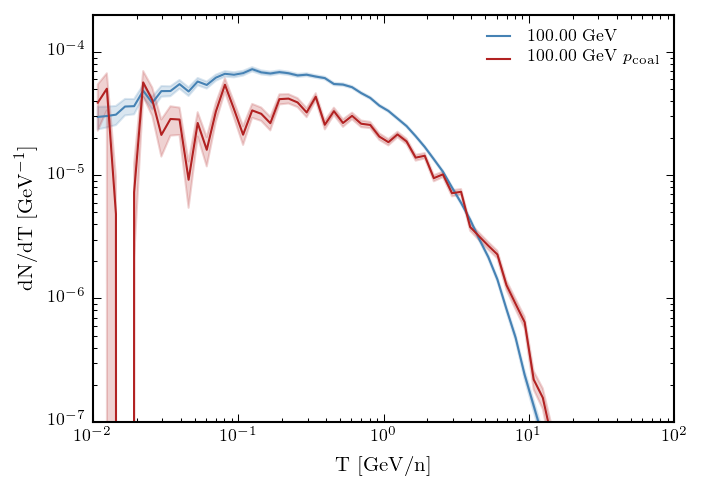

In [85]:


def Propagate_dbar_IS(T, dNdT, m_chi, species,rho_dm=.39, model='MED',sigma_v=3e-26, 
                      prop_func_directory='/data/propagation_functions/'):
    '''
    2-zone diffusion Green Functions for antideuterons min/med/max interstellar propagation assuming an annihilating NFW profile. 

    :params T: Kinetic energy per nucleon [GeV/n]
    :params dNdT: differential count per (Kinetic energy per nucleon) [dbar / (GeV/n)^-1]
    :params m_chi: mass of DM candidate in GeV
    :params species: can be 'dbar' or '3He'
    :params model: 'MIN', 'MED', 'MAX'
    :params sigma_v: Thermal cross-section in cm^3/s
    
    :returns: T, Interstellar CR flux in m^-2 s^-1 sr^-1 
    '''
    
    # Build the propagation function interpolator from data. 
    if species == 'dbar':
        t_prop, P_prop = np.loadtxt(prop_func_directory + '/3He_and_dbar_propagation_functions_ibarra_wild/propagation_functions/'+species+'_ann_MyNFWSmooth_'+model+'_MethodAnn.dat').T
        print t_prop, P_prop
    elif species == '3He':
        t_prop, P_prop = np.loadtxt(prop_func_directory + '/3He_and_dbar_propagation_functions_ibarra_wild/propagation_functions/'+species+'_ann_NFW_'+model+'_MethodAnn.dat').T
    prop_function = lambda x: np.exp(np.interp(np.log(x), np.log(t_prop), np.log(P_prop)))
    # 
    propagated_spectrum = (rho_dm/0.39)**2 * (100./m_chi)**2 *sigma_v/3e-26 * prop_function(np.log(T)) * dNdT
    
    return T, propagated_spectrum
    
    
# Cross-sec method
num_events = 1e8
bins = np.logspace(-2,2,65)
val,bins = np.histogram(cross_sec_dataset['E_d'],bins=bins)
err = np.array([np.sqrt(val[i])/(bins[i+1]-bins[i]) for i in range(len(bins)-1)])/float(num_events*5)
val = np.array([val[i]/(bins[i+1]-bins[i]) for i in range(len(bins)-1)])
val = val/float(num_events)*float(cross_sec_dataset['weight'].iat[0])
bin_centers = np.array([.5*(bins[i+1]+bins[i]) for i in range(len(bins)-1)])
plt.fill_between(bin_centers, val-err,val+err , color='steelblue', alpha=.2)

plt.plot(bin_centers, val , label='%1.2f GeV'%(cross_sec_dataset['E_CMS'].iat[0]/2.))

# coalesence mech
val_pcoal,bins = np.histogram(p_coal_dataset['E_d'],bins=bins)
err_pcoal = np.array([np.sqrt(val_pcoal[i])/(bins[i+1]-bins[i]) for i in range(len(bins)-1)])/float(num_events)
val_pcoal = np.array([val_pcoal[i]/(bins[i+1]-bins[i]) for i in range(len(bins)-1)])
val_pcoal = val_pcoal/float(num_events)*float(p_coal_dataset['weight'].iat[0])
plt.plot(bin_centers, val_pcoal , label=r'%1.2f GeV $p_{\rm coal}$'%(p_coal_dataset['E_CMS'].iat[0]/2.))
plt.fill_between(bin_centers, val_pcoal-err_pcoal,val_pcoal+err_pcoal , color='firebrick', alpha=.2)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('dN/dT [GeV$^{-1}$]')
plt.xlabel('T [GeV/n]')
plt.ylim(1e-7,2e-4)
plt.legend(fontsize=8, frameon=False)

In [82]:

import numpy as np 

def PPPC4DM_prop(T, dNdT, m_chi, species, model='MED',halo='NFW', sigma_v=3e-26, rho_dm=0.39, prop_func_directory='/data/propagation_functions/'):
    '''
    2-zone diffusion Green Functions for antiprotons and antideuterons min/med/max interstellar propagation assuming an annihilating profiles. 
    Based on pppc4dm http://www.marcocirelli.net/PPPC4DMID.html  + arXiv: 1412.5696

    :params T: Kinetic energy per nucleon [GeV/n]
    :params dNdT: differential count per (Kinetic energy per nucleon) [dbar / (GeV/n)^-1]
    :params m_chi: mass of DM candidate in GeV
    :params species: can be 'antiprotons' or 'antideuterons' 
    :params model: Propagation model: 'MIN', 'MED', 'MAX'
    :params halo: DM Halo model: 'NFW', 'Moo', 'Iso', 'Ein', 'EiB', 'Bur'
    :params sigma_v: Thermal cross-section in cm^3/s
    :params rho_dm: Local dark matter density in GeV^-3
    :prop_func_directory: Directory containing the propagation functions from http://www.marcocirelli.net/PPPC4DMID.html
    
    :returns: [T,dNdT]: Kinetic energy per nucleon in GeV/n, Differential Interstellar CR flux in m^-2 s^-1 sr^-1 (GeV/n)^-1
    '''
    # Load the propagation functions from file 
    with open(prop_func_directory + '/Propagation_Ann_R' + species + '.dat') as f: 
        for line in f:
            if halo in line and model in line:
                a = np.array(line.split()[2:]).astype(np.float32)
    
    # This is the propagation function defined by 1412.5696v3 eq14
    prop_function = lambda T: 10**(np.sum([a[i]*np.log10(T)**i for i in range(6)],axis=0))
    
    # Lorentz factors of particle (T is per nucleon so no need to multiply proton mass by A)
    gamma = T/0.938+1.
    # Velocity of particle in cm/s 
    v_p = np.sqrt(1-1/gamma**2)* 2.9979e10
    
    # Rescale based on DM parameters
    #rescaling = v_p/(4*np.pi) * (rho_dm/0.39)**2 * (100./m_chi)**2 * (sigma_v/3e-26) * Myr2sec

    rescaling = v_p/(4*np.pi) * (rho_dm/m_chi)**2 * sigma_v / 2.
    return T, rescaling*prop_function(T)*Myr2sec*dNdT *1e4 # 1e4 to convert from cm^-2 to m^-2



def applyForceField(T_IS,flux,phi=.500, Z=2,A=1,m=2*.938):
    """
    Applies the force-field approximation to the interstellar spectrum passed in. 
    
    :params T_IS: Interstellar Kinetic Energies in GeV
    :params flux: dnde in arb/GeV
    :params phi: Fisk potential in GV
    :params Z: Atomic charge
    :params A: Atomic mass number (for electrons/positron leave A=1 and set m=m_e)
    :params m: particle mass in GeV
    :returns T_TOA, Flux_TOA: Kinetic Energy and dnde at the top of atmosphere. 
    """
    flux_IS = lambda x: np.interp(x, T_IS, flux)
    T_TOA = T_IS-phi*np.abs(Z)/A
    return T_TOA, (2*m*A*T_TOA+(A*T_TOA)**2)/(2*m*A*T_IS+(A*T_IS)**2)*flux_IS(T_IS)

T, dNdT = bin_centers, val
# PPPC4DM 
T, flux = PPPC4DM_prop(T, dNdT, m_chi=100., species='antideuterons', halo='NFW', model='MED', rho_dm=.27 )
T_TOA, flux_TOA = applyForceField(T, flux, phi=.5, A=2, Z=1, m=2*.938)

T, dNdT = bin_centers, val_pcoal
# PPPC4DM 
T, flux_pcoal = PPPC4DM_prop(T, dNdT, m_chi=100., species='antideuterons', halo='NFW', model='MED', rho_dm=.27 )
T_TOA, flux_TOA_pcoal = applyForceField(T, flux_pcoal, phi=.5, A=2, Z=1, m=2*.938)



# Ibarra Wild 2013 
# T_ibarra, flux_ibarra = Propagate_dbar_IS(T, dNdT, m_chi=100, species='dbar', model='MED',sigma_v=3e-26, rho_dm=.26)
# T_TOA, flux_ibarra_TOA = applyForceField(T, flux_ibarra, phi=.5, A=2, Z=1, m=2*.938)

(0.1, 100.0)

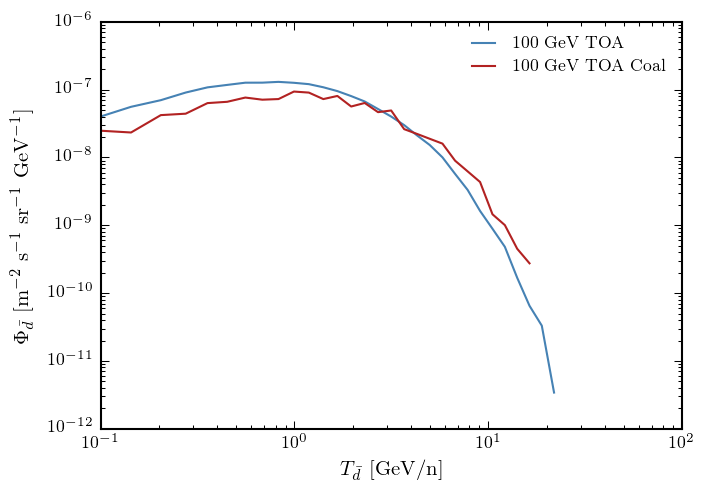

In [83]:
#plt.loglog(T,flux, label='100 GeV IS')
#plt.loglog(T,flux_ibarra, label='100 GeV IS ibarra')
plt.loglog(T_TOA,flux_TOA, label='100 GeV TOA')
#plt.loglog(T_TOA,flux_ibarra_TOA, label='100 GeV TOA ibarra')

#plt.loglog(T,flux_pcoal, label='100 GeV IS Coal')
plt.loglog(T_TOA,flux_TOA_pcoal, label='100 GeV TOA Coal}')


plt.ylabel(r'$\Phi_{\bar{d}}\ \rm [m^{-2}\ s^{-1}\ sr^{-1}\ GeV^{-1}]$',)
plt.xlabel(r'$T_{\bar{d}}\ \rm [GeV/n]$',)
plt.legend(fontsize=8, frameon=False)
plt.xlim(1e-1, 1e2)

In [78]:
import prop
reload(prop)
flux_is = prop.FluxIS(T, dNdT, m_chi=100, nmax=50)
    

(32,) (32,)
[ -2.38332393e-01  -2.34440996e-01  -2.29251734e-01  -2.22331743e-01
  -2.13103787e-01  -2.00798109e-01  -1.84388223e-01  -1.62505290e-01
  -1.33323928e-01  -9.44099579e-02  -4.25173442e-02   2.66825683e-02
   1.18962135e-01   2.42018914e-01   4.06117767e-01   6.24947105e-01
   9.16760716e-01   1.30590042e+00   1.82482656e+00   2.51682568e+00
   3.43962135e+00   4.67018914e+00   6.31117767e+00   8.49947105e+00
   1.14176072e+01   1.53090042e+01   2.04982656e+01   2.74182568e+01
   3.66462135e+01   4.89518914e+01   6.53617767e+01   8.72447105e+01] [  2.09978882e-08   2.41739076e-08   2.78025569e-08   3.19339147e-08
   3.66160761e-08   4.18906060e-08   4.77859178e-08   5.43082646e-08
   7.05538030e-08   1.02733115e-07   1.48238222e-07   2.09545486e-07
   2.93285072e-07   4.08560555e-07   5.63735058e-07   7.65411365e-07
   1.01899095e-06   1.34223210e-06   1.64283663e-06   1.98709992e-06
   2.27551289e-06   2.48710773e-06   2.68003621e-06   2.68218929e-06
   2.68101466e-06   2

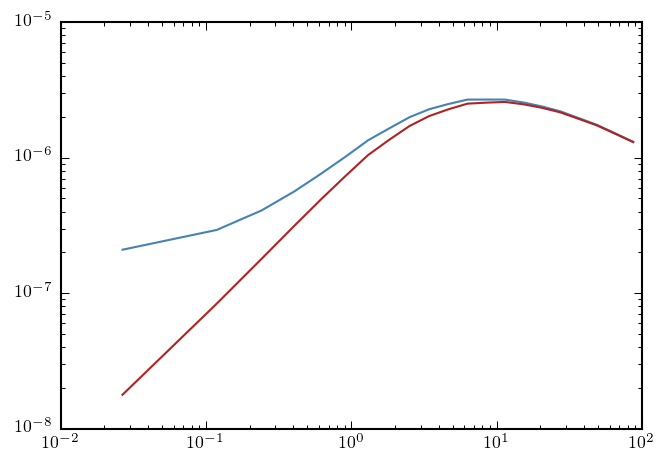

In [81]:
print T.shape, flux_is.shape
T, flux_TOA = prop.applyForceField(T, flux_is, phi=.5, A=2, Z=1, m=2*.938)

print T, flux_is

plt.loglog(T,flux_is)
plt.loglog(T,flux_TOA)


In [95]:
[5*1.5**i for i in range(20)]

[5.0,
 7.5,
 11.25,
 16.875,
 25.3125,
 37.96875,
 56.953125,
 85.4296875,
 128.14453125,
 192.216796875,
 288.3251953125,
 432.48779296875,
 648.731689453125,
 973.0975341796875,
 1459.6463012695312,
 2189.469451904297,
 3284.2041778564453,
 4926.306266784668,
 7389.459400177002,
 11084.189100265503]